In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import wordcloud
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, plot_confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# Reading Data

In [3]:
#Reading Data
# Train Data
traindat = pd.read_csv('training_set_values.csv')
traindat.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# Data Labels
labelsdat = pd.read_csv('training_set_labels.csv')
labelsdat.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
# Data to predict
testdat = pd.read_csv('test_set_values.csv')
testdat.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


# Joining all datasets

In [6]:
# First, review datasets dimensions
print('train: ',traindat.shape[0])
print('labels: ',labelsdat.shape[0])
print('test: ',testdat.shape[0])

train:  59400
labels:  59400
test:  14850


In [7]:
# Review if values are in both datasets (train and labels) and testing if there are no coincidencies between test and
# the other data sets

print('table labels\n',traindat['id'].isin(labelsdat['id']).value_counts())
print('table test\n',traindat['id'].isin(testdat['id']).value_counts())

table labels
 True    59400
Name: id, dtype: int64
table test
 False    59400
Name: id, dtype: int64


In [9]:
# Using this option to see better the datasets
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [10]:
# Doing the merge between train and labels and setting the data to predict
trla=pd.merge(traindat,labelsdat, on="id",how="left")
tot= pd.concat([trla,testdat])

In [11]:
ntrain = trla.shape[0]
ntest = testdat.shape[0]
#Eliminating objective variable from predictive variables and saving it in y_train.
y_train = trla.status_group
tot.drop(['status_group'],axis=1, inplace=True)
print("total data set size is: {}".format(tot.shape))

total data set size is: (74250, 40)


# DEPURATION

In [12]:
# Reviewing information of dataset
tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69746 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74250 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

Some of the variables have missing values and there are lot of variables that are categorical variables.

In [13]:
# Starting with depuration with variables and separating categorical variables from numerical variables
cat_cols= tot.select_dtypes(include=['object','category']).columns
num_cols = tot.select_dtypes(exclude=['object','category']).columns

In [14]:
# Making a describe with categorical columns
tot[cat_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,70095,74250,69404,38992,70457,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,369,2140,2410,45684,9,21425,21,125,2098,2,1,12,2868,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,695,11299,21751,4440,12871,646,6599,3128,386,63749,74250,45917,858,48606,33263,33263,33263,50624,65538,31712,31712,63505,63505,41522,41522,21216,21216,57286,35628,43239


We see that: 
1. Installer, funder, wpt_name, subvillage, ward, scheme_name, and other have a lot of categories
2. wpt_name principal category is none
3. recorded_by have only one unique catogry 

In [15]:
# Making a describe of numeric columns 
tot[num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


The variable id is not a variable that is going to give a lot of information to the model.

Now we proceed to find how many null values are present in the dataset, in which variables and how to treat them.

In [16]:
#Checking null values in the dataset
tot_na = (tot.isnull().sum() / len(tot)) * 100
tot_na = tot_na.drop(tot_na[tot_na == 0].index).sort_values(ascending=False)[:100]
missing_data = pd.DataFrame({'Missing Ratio' :tot_na})
missing_data

,Missing Ratio
scheme_name,47.485522
scheme_management,6.526599
installer,6.103704
funder,6.065993
public_meeting,5.595960
permit,5.108418
subvillage,0.632997


You can noticed that scheme_name is the one that has a lot of null values, it is near to 50% so I decide to take out this variable. The other variables contain less missing null values and are categorical variables so we can create a new category call "other".

In [17]:
nuls = ["scheme_management", "installer", "funder", "public_meeting", "permit", "subvillage"]
for i in nuls:
    tot[i].fillna("other",inplace=True)

For now we have that recorded_by variable has only one unique category, the variable id don't give any useful information and the variable scheme_name has a lot of missing values. This variables are going to be taken off, but before that we are going to create a new variable that uses construction_year and date_recorded.

In [18]:
# Changing date_recorded type to date
tot['date_recorded'] = pd.to_datetime(tot['date_recorded'])

# Printing the first 3 rows of date_recorded but only showing the year
print(tot.date_recorded.dt.year.head(3))

# Printing the first 3 rows of construction_year
print(tot.construction_year.head(3))

# Creating a new colum called operational_year
tot['operational_year'] = tot.date_recorded.dt.year - tot.construction_year
# Printing the result to review if everything is right
tot.operational_year.head(3)

0    2011
1    2013
2    2013
Name: date_recorded, dtype: int64
0    1999
1    2010
2    2009
Name: construction_year, dtype: int64


0    12
1     3
2     4
Name: operational_year, dtype: int64

Once this is created we have to drop the variable date_recorded.

Now we are going to create a new variables that multiply amount_tsh by region_code, by population and construction_year.

In [19]:
tot['operation_region'] = tot.amount_tsh * tot.region_code
tot['operation_population'] = tot.amount_tsh * tot.population
tot['operation_year'] = tot.amount_tsh * tot.construction_year

Now we are going to delete tha variables mentioned above

In [20]:
tot.drop(['id','scheme_name','recorded_by','date_recorded'], axis = 1, inplace = True)

We are going to generate numeric variables that correspond to the different categories of status_group.

In [21]:
# We create the list of conditions using the dataset without the predict values
conditions = [
    (trla['status_group'] == "functional"),
    (trla['status_group'] == "non functional"),
    (trla['status_group'] == "functional needs repair")]
# Creating the list of numeric values that we want to assign.
values = [1, 0, 2]

# We create a new variable called operation
trla['Operation'] = np.select(conditions, values)

Now we review the outliers of the data set.

In [22]:
from scipy.stats import norm, skew

numeric_feats = tot.dtypes[tot.dtypes != 'object'].index
skewed_feats = tot[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew

operation_population    106.371174
num_private              91.325138
operation_region         69.628493
operation_year           58.144767
amount_tsh               56.368883
population               11.780377
district_code             3.961353
region_code               3.179390
operational_year          0.629770
construction_year        -0.629771
longitude                -4.187278
dtype: float64

We noticed that there are several variables with a lot of outliers so we proposed to apply log.

In [23]:
for feature in high_skew.index:
    tot[feature] = np.log1p(np.abs(tot[feature]))

We now change the object variables to categorical variables but with numeric categories.

In [24]:
tot.dtypes[tot.dtypes == 'object'].index

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [25]:
cats = tot.dtypes[tot.dtypes == 'object'].index
for cat in cats:
    tot[cat] = tot[cat].astype('category').cat.codes

In [26]:
tot.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,operational_year,operation_region,operation_population,operation_year
0,8.699681,1548,1390,1706,3.581798,-9.856322,45683,0.0,1,13116,3,2.484907,1.791759,51,1429,4.700480,1,7,0,7.600902,3,1,0,7,4,2,0,6,2,1,1,8,6,0,1,1,2.564949,11.097425,13.390864,16.299917
1,0.000000,522,1399,610,3.575116,-2.147466,45426,0.0,4,17596,9,3.044522,1.098612,103,1581,5.638355,2,2,1,7.606387,3,1,0,11,4,0,2,6,2,2,2,5,3,1,1,1,1.386294,0.000000,0.000000,0.000000
2,3.258097,924,686,2296,3.649636,-3.821329,17767,0.0,5,10096,8,3.091042,1.609438,108,1629,5.525453,1,7,1,7.605890,3,1,0,7,4,4,5,6,2,1,1,0,1,1,2,1,1.609438,6.265301,8.740497,10.824288
3,0.000000,1961,263,2078,3.675950,-11.155298,45537,0.0,7,9998,12,4.510860,4.158883,87,1576,4.077537,1,7,1,7.594381,14,10,5,7,4,0,2,6,2,0,0,3,0,0,2,1,3.332205,0.000000,0.000000,0.000000
4,0.000000,20,0,133,3.469817,-1.825359,43411,0.0,4,8583,4,2.944439,0.693147,26,1692,0.000000,1,12,1,0.000000,3,1,0,1,1,0,2,6,2,3,3,5,3,1,1,1,7.606885,0.000000,0.000000,0.000000


Separating the date between train, test rows and the objective variable.

In [27]:
# Train values
X = tot[:ntrain].values
# Predict values
Z = tot[ntrain:].values
# Objective variable (numeric)
y = trla['Operation'].values

In [28]:
# Creating the correlation matrix
newtot= tot.join(trla['Operation'])

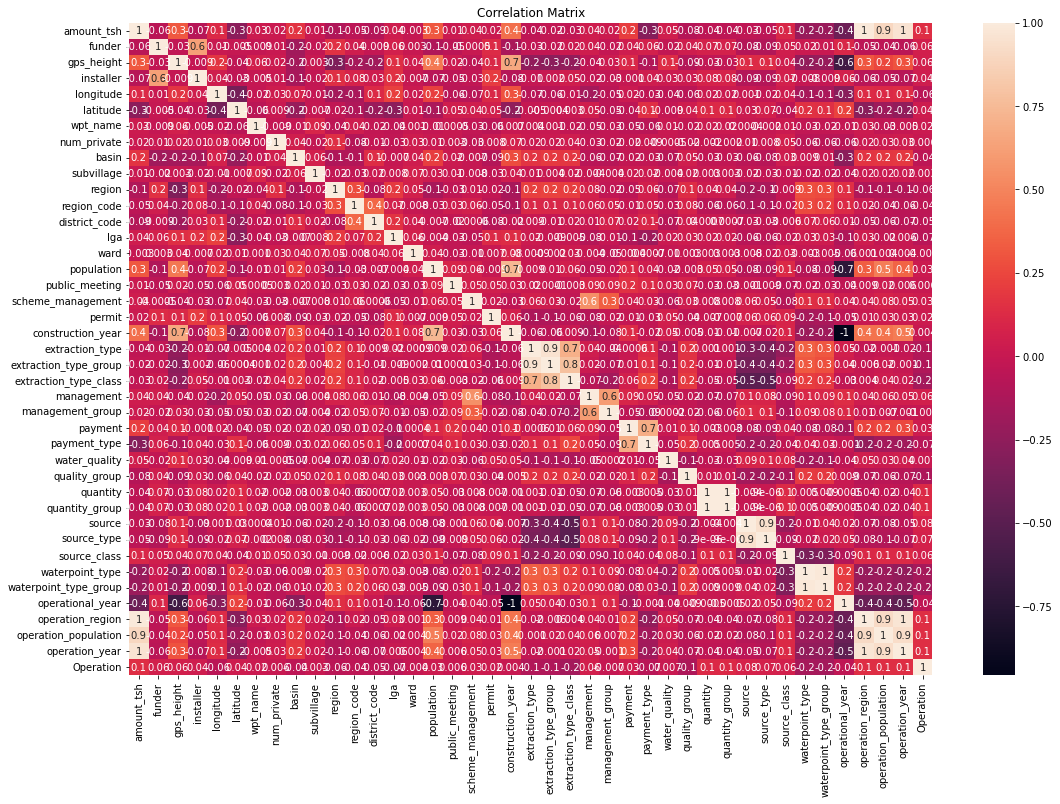

In [29]:
corrM=newtot.corr()
plt.subplots(figsize=(18,12))
sns.heatmap(corrM, annot=True, fmt='.1g')
plt.title('Correlation Matrix')
plt.show()

In [30]:
# Another way to observe the correlation between variables
corr = abs(newtot.corr())
corr[['Operation']].sort_values(by = 'Operation',ascending = False).style.background_gradient()

,Operation
Operation,1.000000
extraction_type_class,0.156309
waterpoint_type_group,0.155481
waterpoint_type,0.152779
operation_year,0.142973
amount_tsh,0.139856
operation_region,0.139731
operation_population,0.137972
quality_group,0.121763
quantity_group,0.119926


We see that the most related variables are extraction_type_class, waterpoint_type, operation_year, amount_tsh, and others.

# USING SMOTE AND BREAKING THE DATA BY TRAIN AND TEST

In [31]:
# Creating a function to create the smote and break the data in train and test
def SMOTEs(X, y):
    # Count how many values of each status_group category are
    counter = Counter(y)
    print('Values before SMOTE: ',counter)
    # Using smote
    smt = SMOTE(random_state=0) #take the max value of all categories and complete other categories to have that value
    X, y = smt.fit_resample(X, y) 
    # Creating test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Count how many values of each status_group category are after smote
    counter = Counter(y)
    print('Values after SMOTE: ',counter)
    return X_train, X_test, y_train, y_test

In [32]:
# Using the function
X_train, X_test, y_train, y_test = SMOTEs(X, y)

Values before SMOTE:  Counter({1: 32259, 0: 22824, 2: 4317})
Values after SMOTE:  Counter({1: 32259, 0: 32259, 2: 32259})


# PREDICTION

We are going to use Random Forest Classifier to find the prediction but before we are going to check wich params work better.

In [296]:
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

param_grid = {
    'n_estimators' : [300,500],
    'max_depth' : [22,21,30]
}

cv = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [22, 21, 30], 'n_estimators': [300, 500]})

In [297]:
cv.best_params_

{'max_depth': 30, 'n_estimators': 300}

In [298]:
# Creating our model, fitting it and predicting the values
RF = RandomForestClassifier(n_estimators=300,max_depth=30,random_state=0)
RF.fit(X_train,y_train)
result = RF.predict(Z)

In [299]:
# Showing the accuracy of the train data and the prediction of test

actr = accuracy_score((model.predict(X_train)), y_train)
acte = accuracy_score((model.predict(X_test)), y_test)
acto = accuracy_score((model.predict(X)), y)

print('Score trainset: ',actr,'\nScore testset: ',acte, '\nScore total: ',acto)

Score trainset:  0.9807933248085144 
Score testset:  0.859630088861335 
Score total:  0.9417676767676768


In [321]:
accuracy = dict()
f1 = dict()

accuracy["RandomForestClassifier"] = accuracy_score(y_test, RF.predict(X_test))
f1["RandomForestClassifier"] = f1_score(y_test, RF.predict(X_test), average="macro")

print(classification_report(y_test, RF.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      6448
           1       0.82      0.89      0.85      6540
           2       0.89      0.91      0.90      6368

    accuracy                           0.86     19356
   macro avg       0.86      0.86      0.86     19356
weighted avg       0.86      0.86      0.86     19356



We can noticed that the prediction of the model is really good with a score value of 0.942 and with the classification report we can see that the value repreent great values for precision and recall. 

In [300]:
predictestdat=pd.DataFrame(result)

In [301]:
predictestdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       14850 non-null  int64
dtypes: int64(1)
memory usage: 116.1 KB


In [302]:
# We again change the numeric categories to the string categories 
conditions = [(result == 1), (result == 0), (result == 2)]
values = ["functional","non functional","functional needs repair"]

# Creating a new column to assing those values 
res = np.select(conditions, values)

# Creating a dataframe with the results
sub = pd.DataFrame()
# Changing the name of the columns to match the challenge rules
sub = pd.DataFrame({"Id":testdat.id, "status_group":res})
# Creating a csv file
sub.to_csv("Concurso_PumpItUp.csv",index=False)
sub.head(3)

,Id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional


With this result we obtain a score value of 0.8176 in the challenge Pump It Up.
  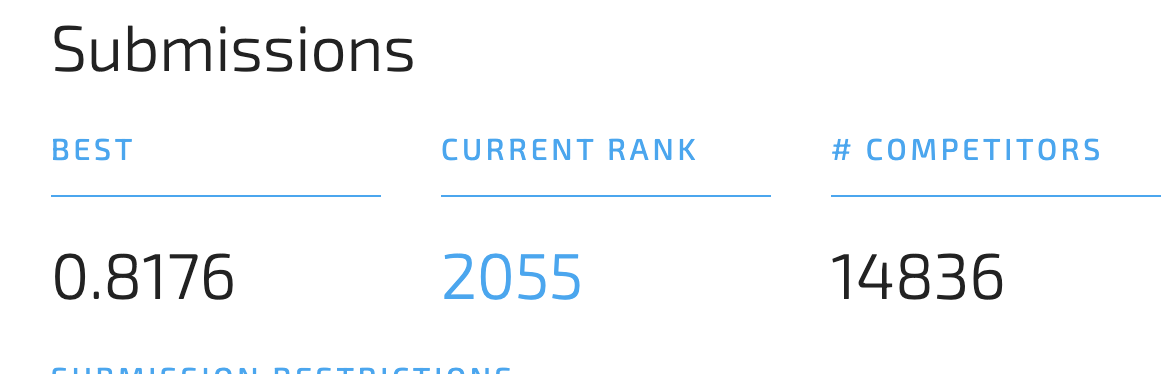